In [44]:
from utils.GraphConvolution import GraphConvolution
import torch
import pandas as pd
import numpy as np


Initialization

In [45]:
class Args:
    weight_decay = 5e-4
    epochs = 1000
    learning_rate = 0.01
    learning_rate_W = 0.01
    dropout = 0.5
    dropout_W = 0.5
    gamma = 1
    no_cuda = False
    train_ratio=0.6
    test_ratio=0.2
    n_classes = 2
    seed = 1234
    torch.manual_seed(seed)
    dataset = "diabetes"
    order = 4
    n_features = 0
    w_val_size = 10
    imbalance_ratio = None
    n_hidden = 0
    setting = None

args = Args()


Dataset specific variables

In [46]:
from utils.data_loader import data_loader_diabetes, data_loader_haberman

diabetes_adj_mtx, diabetes_train_X_df, diabetes_train_Y_df, diabetes_val_X_df, diabetes_val_Y_df, diabetes_test_X_df, diabetes_test_Y_df \
        , diabetes_train_idx, diabetes_val_idx, diabetes_test_idx, diabetes_n_features = data_loader_diabetes(args)

haberman_adj_mtx, haberman_n_features, haberman_n_features, haberman_train_X_df, haberman_val_X_df, haberman_test_X_df, haberman_train_Y_df \
        , haberman_val_Y_df, haberman_test_Y_df, haberman_train_idx, haberman_val_idx, haberman_test_idx = data_loader_haberman(args)

if args.dataset == "diabetes":
    adj_mtx = diabetes_adj_mtx
    n_hidden = [64, 64, 64]
    n_features = diabetes_n_features
    train_X = diabetes_train_X_df
    train_Y = diabetes_train_Y_df
    val_X = diabetes_val_X_df
    val_Y = diabetes_val_Y_df
    test_X = diabetes_test_X_df
    test_Y = diabetes_test_Y_df
    train_idx = diabetes_train_idx
    val_idx = diabetes_val_idx
    test_idx = diabetes_test_idx
elif args.dataset == "haberman":
    adj_mtx = haberman_adj_mtx
    n_hidden = [64]
    n_features = haberman_n_features
    train_X = haberman_train_X_df
    train_Y = haberman_train_Y_df
    val_X = haberman_val_X_df
    val_Y = haberman_val_Y_df
    test_X = haberman_test_X_df
    test_Y = haberman_test_Y_df
    train_idx = haberman_train_idx
    val_idx = haberman_val_idx
    test_idx = haberman_test_idx
else:
    pass

In [53]:
pd.DataFrame(train_Y, columns=['labels']).labels.unique()
.groupby('Team')

array([1., 0.])

In [47]:
assert len(pd.DataFrame(val_Y, columns=['labels']).labels.unique()) == len(pd.DataFrame(train_Y, columns=['labels']).labels.unique()) == len(pd.DataFrame(test_Y, columns=['labels']).labels.unique()), \
    "There are some classes missing in one the 3 partitiones of the dataset"

In [48]:
device = torch.device("cuda" if False else "cpu")


Dataframe to Tensor transformation

In [49]:
features = torch.from_numpy(np.concatenate((train_X, val_X, test_X), axis=0)).to(device)
labels = torch.from_numpy(np.int64(np.concatenate((train_Y, val_Y, test_Y), axis=0))).to(device)
train_idx = torch.from_numpy(np.array(train_idx, dtype=np.int64)).to(device)
val_idx = torch.from_numpy(np.array(val_idx, dtype=np.int64)).to(device)
test_idx = torch.from_numpy(np.array(test_idx, dtype=np.int64)).to(device)
adj_mtx = torch.from_numpy(np.array(adj_mtx, dtype=np.float64)).to(device)

Classifier

In [31]:
from utils.GraphConvolution import GCN_Encoder3, GCN_Classifier
import time
import torch.optim as optim
import torch.nn.functional as F
from utils.evaluation import accuracy, print_class_acc

encoder = GCN_Encoder3(nfeat=n_features,
        nhid=n_hidden,
        nembed=n_hidden[-1],
        dropout=args.dropout,
        nclass=args.n_classes,
        order=1)
classifier = GCN_Classifier(nembed=n_hidden[-1], 
        nhid=n_hidden[-1], 
        nclass=int(labels.max().item()) + 1, 
        dropout=args.dropout, device=device)
optimizer_en = optim.Adam(encoder.parameters(),
                       lr=args.learning_rate, weight_decay=args.weight_decay)
optimizer_cls = optim.Adam(classifier.parameters(),
                       lr=args.learning_rate, weight_decay=args.weight_decay)
def train(epoch):
        t = time.time()
        encoder.train()
        classifier.train()
        optimizer_en.zero_grad()
        optimizer_cls.zero_grad()
        embed = encoder(features, adj_mtx)
        output = classifier(embed, adj_mtx)
        if args.setting == 'reweight':
                weight = "STH"
                loss_train = F.cross_entropy(output[train_idx], labels[train_idx], weight=weight)
        else:
                loss_train = F.cross_entropy(output[train_idx], labels[train_idx])
        acc_train = accuracy(output[train_idx], labels[train_idx])
        loss_train.backward()
        optimizer_en.step()
        optimizer_cls.step()
        loss_val = F.cross_entropy(output[val_idx], labels[val_idx])
        acc_val = accuracy(output[val_idx], labels[val_idx])
        print_class_acc(output[val_idx], labels[val_idx])
        print('Epoch: {:05d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
        
        return acc_train.item(), acc_val.item(), loss_train.item(), loss_val.item()


In [33]:
acc_trains = []
acc_vals = []
loss_trains = []
loss_vals = []

for epoch in range(args.epochs):
        acc_train, acc_val, loss_train, loss_val = train(epoch)
        acc_trains.append(acc_train)
        acc_vals.append(acc_val)
        loss_trains.append(loss_train)
        loss_vals.append(loss_val)


valid current auc-roc score: 0.508734, current macro_F score: 0.429630
Epoch: 00001 loss_train: 4229719.9717 acc_train: 0.6196 loss_val: 2401084.3771 acc_val: 0.7532 time: 0.0324s
valid current auc-roc score: 0.585413, current macro_F score: 0.585809
Epoch: 00002 loss_train: 785699.2619 acc_train: 0.5804 loss_val: 307581.2498 acc_val: 0.7273 time: 0.0253s
valid current auc-roc score: 0.504310, current macro_F score: 0.197917
Epoch: 00003 loss_train: 2486678.6141 acc_train: 0.3783 loss_val: 3059163.4079 acc_val: 0.2468 time: 0.0257s
valid current auc-roc score: 0.514406, current macro_F score: 0.356464
Epoch: 00004 loss_train: 482119.1774 acc_train: 0.4283 loss_val: 558384.1365 acc_val: 0.3571 time: 0.0230s
valid current auc-roc score: 0.495690, current macro_F score: 0.425373
Epoch: 00005 loss_train: 498882.6891 acc_train: 0.6152 loss_val: 228954.9347 acc_val: 0.7403 time: 0.0185s
valid current auc-roc score: 0.517468, current macro_F score: 0.429630
Epoch: 00006 loss_train: 401416.687

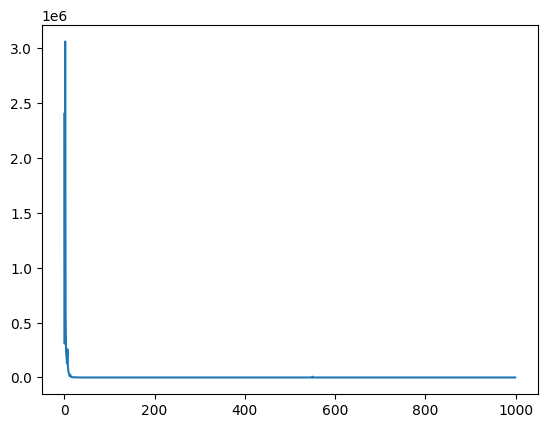

In [41]:
import matplotlib.pyplot as plt
# plt.plot(acc_trains)
# plt.plot(acc_vals)
# plt.plot(loss_trains)
plt.plot(loss_vals)

plt.show()

GraphSMOTE's implementation

In [ ]:
def recon_upsample(embed, labels, idx_train, adj=None, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    avg_number = int(idx_train.shape[0]/(c_largest+1))
    adj_new = None
    for i in range(im_class_num):
        chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        num = int(chosen.shape[0]*portion)
        if portion == 0:
            c_portion = int(avg_number/chosen.shape[0])
            num = chosen.shape[0]
        else:
            c_portion = 1

        for j in range(c_portion):
            chosen = chosen[:num]

            chosen_embed = embed[chosen,:]
            distance = squareform(pdist(chosen_embed.cpu().detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            new_embed = embed[chosen,:] + (chosen_embed[idx_neighbor,:]-embed[chosen,:])*interp_place


            new_labels = labels.new(torch.Size((chosen.shape[0],1))).reshape(-1).fill_(c_largest-i)
            idx_new = np.arange(embed.shape[0], embed.shape[0]+chosen.shape[0])
            idx_train_append = idx_train.new(idx_new)

            embed = torch.cat((embed,new_embed), 0)
            labels = torch.cat((labels,new_labels), 0)
            idx_train = torch.cat((idx_train,idx_train_append), 0)

            if adj is not None:
                if adj_new is None:
                    adj_new = adj.new(torch.clamp_(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                else:
                    temp = adj.new(torch.clamp_(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                    adj_new = torch.cat((adj_new, temp), 0)

    if adj is not None:
        add_num = adj_new.shape[0]
        new_adj = adj.new(torch.Size((adj.shape[0]+add_num, adj.shape[0]+add_num))).fill_(0.0)
        new_adj[:adj.shape[0], :adj.shape[0]] = adj[:,:]
        new_adj[adj.shape[0]:, :adj.shape[0]] = adj_new[:,:]
        new_adj[:adj.shape[0], adj.shape[0]:] = torch.transpose(adj_new, 0, 1)[:,:]

        return embed, labels, idx_train, new_adj.detach()

    else:
        return embed, labels, idx_train

train & eval

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import pickle


def encode_onehot_torch(labels):
    num_classes = int(labels.max() + 1)
    y = torch.eye(num_classes)
    return y[labels]


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot